## Reacciones y condensación

Este código calcula la evolución del nro de partículas de cada especie en función del tiempo dentro de la burbuja considerando distintos fenómenos:
* Reacciones
* Condensación

### Importo dependencias

In [1]:
#Importo dependencias
import scipy
import pandas as pd
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
#Código necesario para importar funciones de otros notebooks .ipynb

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

#Ejemplo
# from derivada_reacciones import *

In [3]:
#Importo notebooks

from parametros import *
from reacciones import *
from funciones_math import fact, erf

importing Jupyter notebook from parametros.ipynb
importing Jupyter notebook from reacciones.ipynb
importing Jupyter notebook from funciones_math.ipynb


### Parámetros de la evolucicón

### Parámetros del método numérico

In [4]:
#Temporal integration control
# eps=1.0e-7;#error
# step=1.0e-11; #Time step [s]
# hmin=1.0e-16; #el paso minimo que debe tener en cuenta
# numciclos=1; #numero de ciclos que calcula NO USADO
epsilon=1.0e-6; #Convergence criterion para las cantidades que se calculan con el metodo de biseccion[1]. Lo necesito para, entre otras cosas, calcular m_punto.
# N=100; # cantidad de pasos utilizados para integrar la funcion error (ERF()). No lo uso porque en Python uso directamente la función math.erf() para calcular la función error.



#### Condiciones iniciales

In [5]:
#Condiciones iniciales
#Orden:
#n[n_species] = {n[0],     n[1],   n[2],   n[3],   n[4],   n[5],   n[6],   n[7]}
#n[n_species] =      {H2,       H,      O,      O2,     OH,     H2O,    H2O2,   HO2}
#n0[n_species] = {0.0,   0.0,   0.5e8,    0.5e8,  0.0}
#n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0])
n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0,    1.0e8,    0.0,    0.0])




In [6]:
#Funciones químicas

def masa(n):
    #Calcula la masa total de las partículas dentro de la burbuja
    m = 0.0
    for i in range(n_species):
        m = m + n[i]*masa_species[i]
    return m


#Función de control durante la evolución

def imprimir_nro_particulas(n_species,n,t, m0):
    #Imprime el tiempo, el nro de partículas de cada especie y la masa normalizada a la masa inicial.
    print(t, "\t", n[0], "\t", n[1], "\t", n[2], "\t", n[3], "\t", n[4], "\t", n[5], "\t", n[6], "\t", n[7], "\t", masa(n)/m0)


In [7]:
#Calculo la masa inicial
m0 = masa(n0)

In [8]:

def Conductividad1(k1):
    #funcion que asigna el termino independiente de la conductividad de cada especie
    #k=k1+k2*T

    k1[0]=k1H2 #Antes k1[0]
    k1[1]=k1H #Antes k1[1]
    k1[2]=k1O #Antes k1[2]
    k1[3]=k1O2 #Antes k1[3]
    k1[4]=k1OH #Antes k1[4]
    k1[5]=k1h2o #Antes k1[5]
    #    k1[7]=k1N
    #    k1[8]=k1NH
    #    k1[9]=k1NH2
    #    k1[10]=k1NH3
    #    k1[11]=k1N2H
    #    k1[12]=k1NO
    #    k1[13]=k1NO2
    #    k1[14]=k1N2H
    #    k1[15]=k1HNO
    #    k1[16]=k1N2
    #    k1[17]=k1Ar
    k1[6]=k1h2o #Antes k1[18]
    k1[7]=k1h2o #Antes k1[19]


def Conductividad2(k2):
    #funcion que asigna el termino lineal de la conductividad de cada especie
    #k=k1+k2*T

    k2[0]=k2H2 #Antes k2[1]
    k2[1]=k2H #Antes k2[2]
    k2[2]=k2O #Antes k2[3]
    k2[2]=k2O2 #Antes k2[4]
    k2[4]=k2OH #Antes k2[5]
    k2[5]=k2h2o #Antes k2[6]
    # k2[7]=k2N
    # k2[8]=k2NH
    # k2[9]=k2NH2
    # k2[10]=k2NH3
    # k2[11]=k2N2H
    # k2[12]=k2NO
    # k2[13]=k2NO2
    # k2[14]=k2N2H
    # k2[15]=k2HNO
    # k2[16]=k2N2
    # k2[17]=k2Ar
    k2[6]=k2h2o #Antes k2[18]
    k2[7]=k2h2o #Antes k2[19]


def MasaMolar(Masa):
    #funcion que asigna la masa molar a cada especie
    #Masa: array que contiene n_species elementos
    #Esta función debería ser cambiada si se tienen en cuenta menos o más elementos.
    
    Masa[0]=MH2
    Masa[1]=MH
    Masa[2]=MO
    Masa[3]=MO2
    Masa[4]=MOH
    Masa[5]=Mh2o

    # Masa[7]=MN
    # Masa[8]=MNH
    # Masa[9]=MNH2
    # Masa[10]=MNH3
    # Masa[11]=MN2H
    # Masa[12]=MNO
    # Masa[13]=MNO2
    # Masa[14]=MN2O
    # Masa[15]=MHNO
    # Masa[16]=MN2
    # Masa[17]=MAr

    Masa[6] = MH2O2 #Antes llamado Masa[18]
    Masa[7] = MHO2 #Antes llamado Masa[19] 


def masa_media_por_particula(ntot, n):
    #Calcula la masa media por particula
    #ntot: nro total de partículas
    
    Masa = np.zeros(n_species) #Creo el vector de masas que contiene las masas de cada especi
    MasaMolar(Masa) #Inicializo las masas

    #Calculo la masa media por particula m
    M=0.0
    icont=1
    for i in range(n_species):
        M=M+(Masa[i]*n[i])/Na
    m=M/ntot

    return m


def Conductividad_termica_k(y3,n,ntot):
    #Calcula la conductividad térmica k que aparece en la ec. 2.2.9.1.1

    k=0.0

    k1 = np.zeros(n_species)
    k2 = np.zeros(n_species)
    Conductividad1(k1)
    Conductividad2(k2)

    for i in range(n_species):
        k=k+(k1[i]+k2[i]*y3)*n[i]/ntot

    return k


In [9]:
#Modelos para calcular TB.

def landa(V, sigmap, ntot):
    #Calcula el camino libre medio
    #V: volumen
    #sigmap:
    #ntot: nro total de partículas

    return V/(math.sqrt(2.0)*sigmap*ntot)


#metodo de Yasui
def calculaTBY(Tmin, Tmax, epsilon, TLi, k, landa, np_, T, m):
    #Calcula TB a partir del método de Yasui empleando la expresión 2.2.1.10. Para calcular q'' utiliza la expresión 2.2.9.1.1

    #Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
    #epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
    #TLi es la temperatura en la pared de la burbuja del lado externo
    #k es la conductividad que depende de la temperatura
    #landa es una funcion que depende de la temperatura
    #np_ es la densidad de numero de moleculas
    #T es la temperatura en el interior de la burbuja


    while((Tmax-Tmin)>epsilon):

        f1=Tmax-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tmax-T)/(n_Yasui*landa)

        x=(Tmax+Tmin)/2.0

        f3=x-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(x-T)/(n_Yasui*landa)
        if(f1*f3>0):
            Tmax=x
        else:
            Tmin=x

    return x




In [10]:
def longitud_termica(t,k,nh2o0,nAr):
  #Calcula la longitud térmica lth necesaria para calcular T_B mediante el método de Toegel
  
  Xi=k/(8.0/2.0*nh2o0*K+5.0/2.0*nAr*K)

  if(Velocidad(t) == 0):
    lth=R(t)/math.pi
  else:
    if((R(t)/math.pi)<(math.sqrt(R(t)*Xi/abs(Velocidad(t))))):
      lth=R(t)/math.pi
    else:
      lth=math.sqrt(R(t)*Xi/abs(Velocidad(t)))
  return lth


#metodo de Toegel
def calculaTBT(Tmin, Tmax, epsilon, TLi, k, lth, np_, T, m):

  #Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
  #epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
  #TLi es la temperatura en la pared de la burbuja del lado externo
  #k es la conductividad que depende de la temperatura
  #landa es una funcion que depende de la temperatura
  #np_ es la densidad de numero de moleculas. Tuve que cambiarlo a np_ en lugar de np porque Python me lo confundía con Numpy
  #T es la temperatura en el interior de la burbuja

  while((Tmax-Tmin)>epsilon):

    f1=Tmax-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth)

    x=(Tmax+Tmin)/2.0

    f3=x-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth)


    if(f1*f3>0):
      Tmax=x
    else:
      Tmin=x
    




  return x




In [11]:
#Función que calcula m_punto.

def TLi(t):
   #Temperatura del líquido en la interfase.
   return 300 #A priori considero que es aproximadamente la temperatura ambiente

def T_unknown(t):
   #Temperatura "T" que aparece en la expresión 2.2.1.7 para calcular Gamma
   return T(t) #A priori considero que es igual a la temperatura T(t)

def y3(t):
   #Creo que esta es la temperatura del Líquido
   return 300
   #return T(t)
   
def y5(t):
   return T(t)


def calculamp_formal(mpmin,mpmax,epsilon, pvap, pv,T,TLi,TB):
   # Calcula m_punto formalmente a partir de la expresión 2.2.1.3 considerando varios factores como entrada
   # mpmin y mpmax son parámetros mínimos y máximos para el cálculo por bisección. Están definidos en Parámetros
   # epsilon es la tolerancia para el cálculo por bisección. Está definida en Parámetros
   # pvap es la presión de vapor saturado a la temperatura del líquido en la interfase T_{L,i}. Está definida en parámetros
   # pv es la presión parcial correspondiente al vapor
   # T ((creo que es la temperatura de la burbuja))
   # TLi es la temperatura del líquido en la interfase
   # TB es la temperatura de la mezcla en la superficie de la burbuja

   if(alfaM > 0):
      while ((mpmax-mpmin)>epsilon):
         #mp es la resta de los mp de evaporacion y de condensacion
         Omega=mpmax/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))
         f1=mpmax-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(TB))

         x=(mpmin+mpmax)/2.0

         Omega=x/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))

         f3=x-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(TB))

         if(f1*f3>0):
            mpmax=x
         else:
            mpmin=x
      #fin del while

      return x
      #devuelve el valor de mp como la raiz de la ecuacion trascendente con tolerancia epsilon
   #fin del if
   else:
      x=0
      return x

def n_tot(n):
   #Función que calcula el número total de partículas de una mezcla
   suma = 0
   for i in range(n_species):
      suma = suma + n[i]
   return suma

def ctes_VanderWaals(ngas, nvap, ntot):
   #Calculo las ctes de Van de Waals a partir de las ecs 2.2.2.2 y 2.2.2.3
   #ngas = ng es la cantidad de partículas de gas no condensable
   #nvap = nv es la cantidad de partículas de vapor (h2o)
   #ntot = nt es la cantidad de partículas totales.

   a_g = a_Ar
   b_g = b_Ar

   a_v = a_h2o
   b_v = b_h2o

   a_gv = math.sqrt(a_g*a_v) #VW gas-vapor a_{g-v}. Antes se llamaba a_Arh2o
   b_gv = pow(0.5*(pow(b_g,1.0/3.0)+pow(b_v,1.0/3.0)),3.0) #VW gas-vapor b_{g-v}. Antes se llamaba b_Arh2o


   a = a_g*(ngas/ntot)**2 + 2.0*a_gv*(ngas/ntot)*(nvap/ntot)+ a_v*(nvap/ntot)*(nvap/ntot) #const a de VW promediada con la cantidad de particulas
   b = b_g*(ngas/ntot)**2 + 2.0*b_gv*(ngas/ntot)*(nvap/ntot)+ b_v*(nvap/ntot)*(nvap/ntot) #const b de VW promediada con la cantidad de particulas

   return a,b

def volumen_molar(V, ntot):
   # Calcula el volumen molar, necesario en el cálculo de la presión del gas empleando la ec. de Van der Waals.
   # V es el volumen total
   # ntot es el nro total de partículas
   # Na es el nro de Avogadro
   v=V/ntot*Na #volumen molar
   return v

def calculamp(t, n, n_h2o, ntot, rapidez, nh2o0, nAr):
   # Calcula m_punto a partir de la expresión 2.2.1.3. Calcula también las variables necesarias para hacer la cuenta
   # t es el tiempo. Se usa para calcular V(t), T(t), T_unknown(t). En el caso gral debería sacar esto
   # n_h2o es la cantidad de partículas de h2o
   # ntot es la cantidad de partículas totales
   # rapidez indica si se quiere hacer la cuenta rápido o lento. Esencialmente, lo único que cambia es si va a calcular la función error o no.
   # TB es la temperatura de la mezcla en la superficie de la burbuja
   
   #Nro de partículas de gas no condensable.
   ngas=ntot-n_h2o

   #Calculo las constantes de Van der Waals:
   a,b = ctes_VanderWaals(ngas, n_h2o, ntot)
   v = volumen_molar(V(t), ntot) #volumen molar

   #Presion del gas calculada a partir de 2.2.2.1 empleando la ec. de Van der Waals.
   pg=Rg*y3(t)/(v-b)-a/(v*v)

   #NO SÉ LO QUE ES ESTO NI SIQUIERA SI SE USA:
   pgg=ngas/ntot*pg

   pvap=pvap0 #parámetro definido en Parámetros

   #Presion parcial del vapor de agua. Se calcula con 2.2.1.6 a partir del nro de partículas de vapor (agua), el nro total de partículas y la presión total dentro de la burbuja
   pv=n_h2o/ntot*pg 

   #Calculo TB: existen distintos modelos pero primero calculo las variables que afectan a todos ellos
   k = Conductividad_termica_k(y3(t),n,ntot)
   landa_ = landa(V(t), sigmap, ntot)
   np_=ntot/V(t) #tuve que cambiarle el nombre a np_ porque si no Python creía que estaba llamando al paquete np Numpy
   m = masa_media_por_particula(ntot, n)


   if(modelo == 1):
      TB= calculaTBY(Tmin,Tmax,epsilon,y5(t),k,landa_,np_,y3(t),m)
   if(modelo == 2):
      lth = longitud_termica(t,k,nh2o0,nAr)
      TB= calculaTBT(Tmin,Tmax,epsilon,y5(t),k,lth,np_,y3(t),m)

   #Hago el cálculo de mp dependiendo del parámetro rapidez. Esto afecta en la rapidez del cálculo
   if(rapidez==1):
      #tengo que hacer esto para que la función math.sqrt() tenga como argumento un nro y no una función TLi(t).
      mp=alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(y5(t))-pv/math.sqrt(TB))
   else:
      mp=calculamp_formal(mpmin,mpmax,epsilon,pvap,pv,y3(t),y5(t),TB(t))
   
   return mp


In [12]:
def condensacion(t,n, dndt):
    #Calcula el efecto de la condensación y evaporación. No considera el efecto de la difusión (2do término de 2.2.3.1)
    #Lo incorpora a dndt (solo al vapor H2O)
    #t es el tiempo necesario para calcular R(t), V(t) y T(t)

    nh2o0 = n0[5]
    nAr = 0 #Consideramos que no hay Argón

    mp = calculamp(t , n, n[5], n_tot(n), rapidez, nh2o0, nAr)

    dndt[5]= dndt[5] + 4.0*math.pi*(R(t)**2)*(mp*Na/Mh2o) #variacion de la cantidad de particulas
    #de vapor de agua debido a la condensacion, mas por difusion y reacciones quimicas
    #(CREO QUE NO ESTÁ CONTENIDA LA DIFUSIÓN)

    return 

In [13]:

def derivada(t, n):
    #Calculo la derivada dndt
    dndt = np.zeros(n_species)

    #Actualizo las variables termodinámicas
    var_termo = np.array([R(t), Vol(t), T(t)])

    derivada_reacc_qcas(var_termo,n,dndt)
    condensacion(t,n,dndt)

    imprimir_nro_particulas(n_species,n,t, m0)

    
    return dndt

In [14]:


#Creo el vector de nro de partículas y lo inicializo
n = np.zeros(n_species)
for i in range(n_species):
    n[i] = n0[i]

#Creo el vector de variables termodinámicas
var_termo = np.zeros(3)


t0=0.0; #Inicializacion del tiempo
    
#Creo el vector de dndt y lo inicializo
dndt = np.zeros(n_species)
dndt = derivada(t0, n)



    # //Creo el file en el que voy a ir guardando todo
    # ofstream file(archivo);
    # file << encabezado << endl;

imprimir_nro_particulas(n_species, n, t0, m0) #imprimo la cantidad inicial de partículas de cada especie
#step es el htry, es decir, el salto que (intenta hacer?) el rkqc.

#-------------------------------------------------------------------------------------------------------------------------
#SOLUCIÓN NUMÉRICA EMPLEANDO EL MÉTODO Radau
soln = solve_ivp(derivada, [t0, tmax], n0, method='Radau')
#Considerando condensación, no terminó de ejecutarse al cabo de 20' con tmax = 100e-6


0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
1.730011718507472e-21 	 99999999.99999756 	 1.4428216613921607e-05 	 7.366332871265667e-07 	 99999999.99999963 	 9.554262752094147e-06 	 99999999.9999889 	 0.0 	 0.0 	 0.9999999999999943
0.0 	 99999998.50988388 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999989291479
0.0 	 100000000.0 	 1.4901161193847656e-14 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 99999998.50988388 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999914936953
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 999999

In [15]:
print(soln) #para obtener info. sobre cómo fue la integración numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 724
     njev: 33
      nlu: 152
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.73001172e-19, 1.90301289e-18, 1.92031301e-17,
       1.92204302e-16, 1.92221602e-15, 1.92223332e-14, 1.92223505e-13,
       7.73921842e-13, 1.80554318e-12, 3.44363836e-12, 5.89724693e-12,
       9.55040824e-12, 1.52270669e-11, 2.50927762e-11, 4.70101930e-11,
       1.03179354e-10, 1.74095354e-10, 2.99363439e-10, 5.05850283e-10,
       8.57654649e-10, 1.38768020e-09, 2.21995242e-09, 3.19102832e-09,
       4.16210422e-09, 5.37173601e-09, 6.96886001e-09, 9.28591827e-09,
       1.23589485e-08, 1.54086421e-08, 2.04395498e-08, 2.75772935e-08,
       3.74480200e-08, 4.94602787e-08, 6.86197377e-08, 8.92284049e-08,
       1.20546419e-07, 1.54797848e-07, 2.01107155e-07, 2.65754849e-07,
       3.10482261e-07, 3.69653682e-07, 4.15967751e-07, 4.62281820e-07,
       5.44260408e-07, 6.24898349e-07

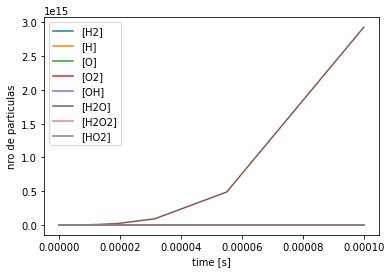

243953033.74080586


In [16]:
#plt.figure(dpi=1200) #Para mayor resolución
plt.plot(soln.t, soln.y[0], label='[H2]')
plt.plot(soln.t, soln.y[1], label='[H]')
plt.plot(soln.t, soln.y[2], label='[O]')
plt.plot(soln.t, soln.y[3], label='[O2]')
plt.plot(soln.t, soln.y[4], label='[OH]')
plt.plot(soln.t, soln.y[5], label='[H2O]')
plt.plot(soln.t, soln.y[6], label='[H2O2]')
plt.plot(soln.t, soln.y[7], label='[HO2]')
plt.xlabel('time [s]')
plt.ylabel('nro de particulas')
plt.legend()
plt.show()

print(soln.y[0,-1])
#243953033.74080586
#243953033.74080586


test


In [17]:
test()

NameError: name 'test' is not defined